In [3]:
import numpy as np
import torch
from collections import Counter
import matplotlib.pyplot as plt
from torch_geometric.data import Dataset, DataLoader

from src.encoding.configs_and_constants import ZINC_SMILES_HRR_7744_CONFIG_F64
from src.encoding.graph_encoders import load_or_create_hypernet
from src.utils.utils import GLOBAL_MODEL_PATH


def analyze_dataset(ds: Dataset, name: str = "", feature_attr: str = "x") -> dict:
    """
    Compute statistics for a PyG dataset with 4-tuple node features
    and draw histograms for node counts, edge counts, and node-type distribution.
    """
    num_nodes_list, num_edges_list = [], []
    node_type_counter = Counter()
    logp_list: list[float] = []  # <-- collect logP if available

    for data in ds:
        n = int(data.num_nodes)
        e = int(data.num_edges) // 2  # dataset is undirected
        num_nodes_list.append(n)
        num_edges_list.append(e)

        x: torch.Tensor = getattr(data, feature_attr)
        if x.dim() != 2 or x.size(1) != 4:
            raise ValueError(f"Expected {feature_attr} shape [N, 4], got {tuple(x.shape)}")
        rows = x.detach().cpu().to(torch.int64).tolist()
        node_type_counter.update(map(tuple, rows))

        # --- logP (optional) ---
        if hasattr(data, "logp"):
            lp = data.logp
            # accept scalar tensor or 1-element tensor
            if isinstance(lp, torch.Tensor):
                lp = float(lp.detach().cpu().reshape(-1)[0])
            else:
                lp = float(lp)
            logp_list.append(lp)

    def stats(arr):
        arr = np.asarray(arr)
        return {
            "min": int(arr.min()),
            "max": int(arr.max()),
            "mean": float(arr.mean()),
            "median": float(np.median(arr)),
            "std": float(arr.std(ddof=1)) if len(arr) > 1 else 0.0,
        }

    summary = {
        "dataset": name,
        "num_graphs": len(ds),
        "nodes": stats(num_nodes_list),
        "edges": stats(num_edges_list),
        "total_node_types": len(node_type_counter),
        "node_type_distribution": dict(node_type_counter),
    }

    if logp_list:
        summary["logp"] = stats(logp_list)  # include logP stats if present


    # --- plotting ---
    fig = plt.figure(figsize=(16, 10))  # wider and taller canvas
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 3])  # bottom row 3x taller

    ax_nodes = fig.add_subplot(gs[0, 0])
    ax_edges = fig.add_subplot(gs[0, 1])
    ax_types = fig.add_subplot(gs[1, :])  # spans the whole width

    # Add a little more margin at the bottom so rotated labels fit
    plt.subplots_adjust(bottom=0.25)

    # Node count distribution
    ax_nodes.hist(num_nodes_list, bins=40, color="steelblue", edgecolor="black")
    ax_nodes.set_title(f"{name} – Node count distribution")
    ax_nodes.set_xlabel("num_nodes")
    ax_nodes.set_ylabel("frequency")

    # Edge count distribution
    ax_edges.hist(num_edges_list, bins=40, color="darkorange", edgecolor="black")
    ax_edges.set_title(f"{name} – Edge count distribution")
    ax_edges.set_xlabel("num_edges")
    ax_edges.set_ylabel("frequency")

    # Node type distribution (wider)
    if node_type_counter:
        labels, counts = zip(*node_type_counter.most_common())
        ax_types.bar(range(len(labels)), counts, color="seagreen", edgecolor="black")
        ax_types.set_xticks(range(len(labels)))
        ax_types.set_xticklabels([str(l) for l in labels], rotation=90, fontsize=8)
    ax_types.set_title(f"{name} – Node type distribution")
    ax_types.set_xlabel("node type (tuple)")
    ax_types.set_ylabel("count")

    plt.tight_layout()
    plt.show()

    # --- separate logP plot (only if available) ---
    if logp_list:
        fig2 = plt.figure(figsize=(8, 5))
        ax_logp = fig2.add_subplot(1, 1, 1)
        ax_logp.hist(logp_list, bins=100, edgecolor="black")
        ax_logp.set_title(f"{name} – logP distribution")
        ax_logp.set_xlabel("cLogP (RDKit)")
        ax_logp.set_ylabel("frequency")
        plt.tight_layout()
        plt.show()

    return summary


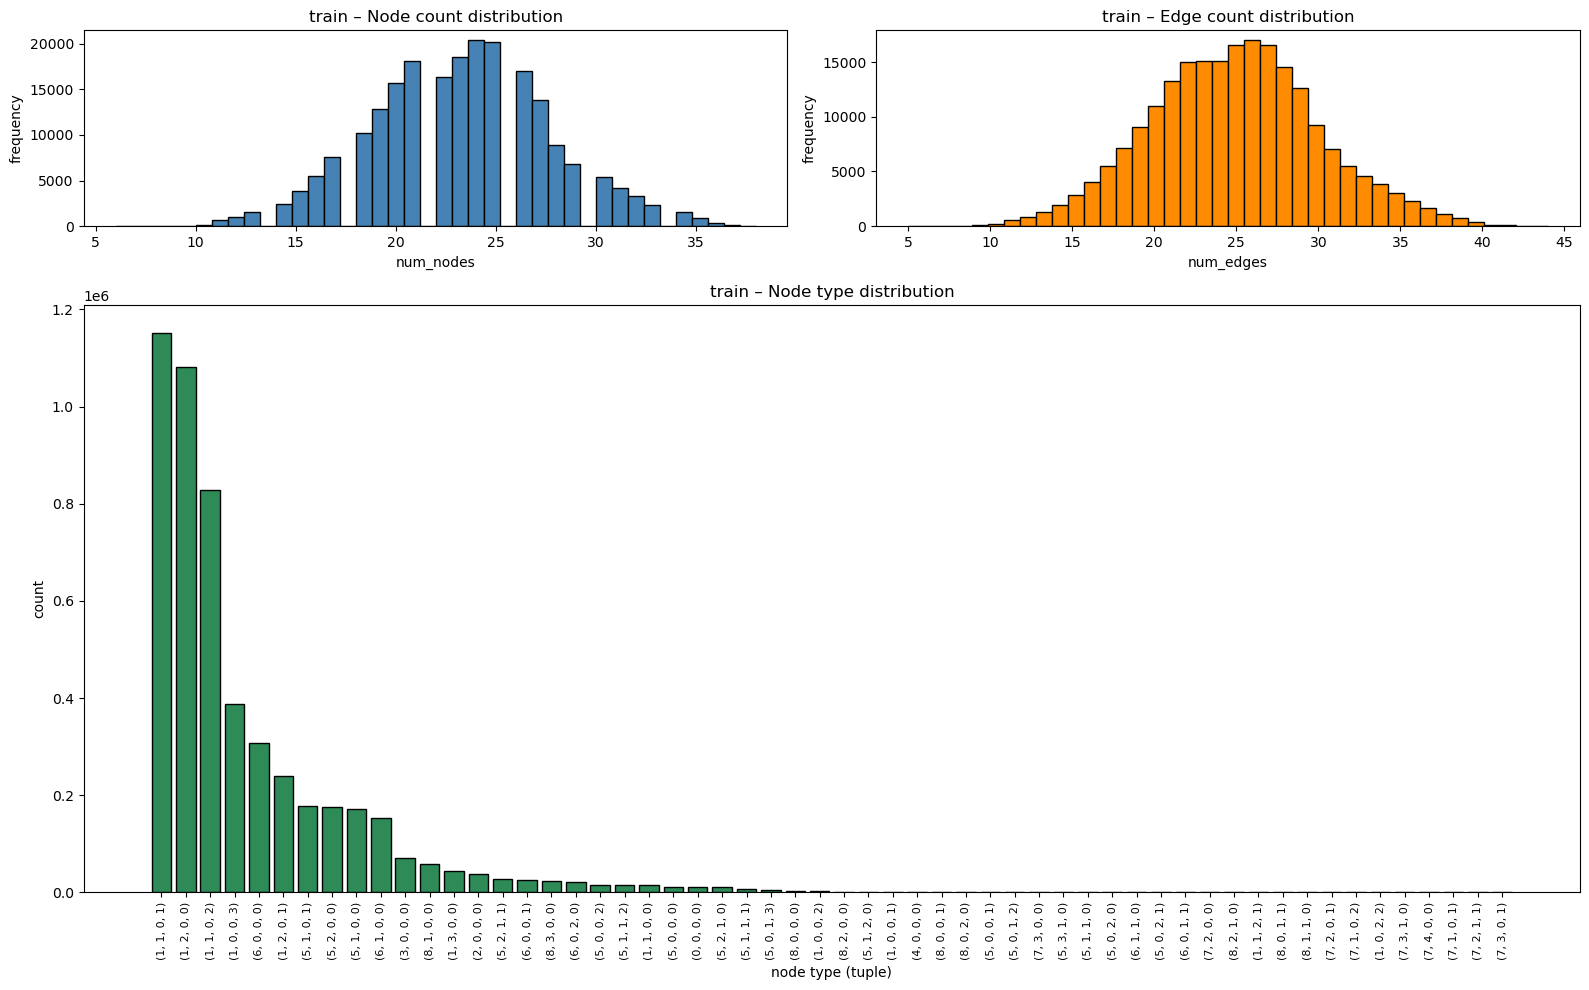

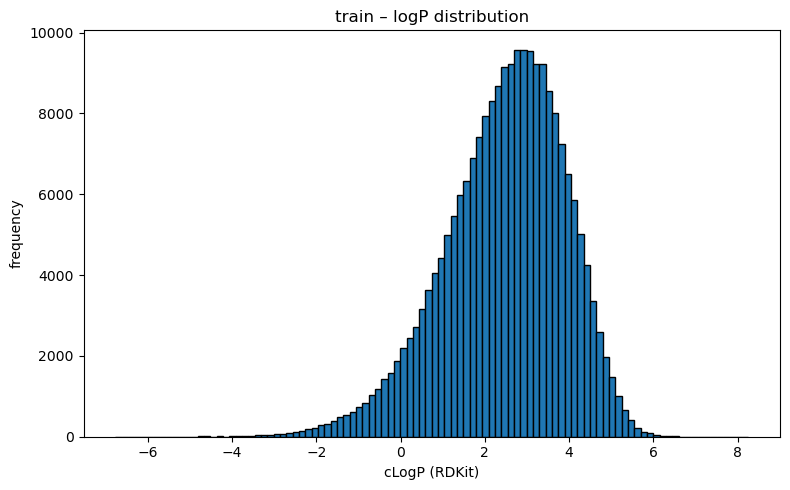

{'dataset': 'train',
 'edges': {'max': 44,
           'mean': 24.906559217493673,
           'median': 25.0,
           'min': 5,
           'std': 5.2931777992057825},
 'logp': {'max': 8,
          'mean': 2.457799800788871,
          'median': 2.60617995262146,
          'min': -6,
          'std': 1.4334213538628746},
 'node_type_distribution': {(0, 0, 0, 0): 11241,
                            (1, 0, 0, 1): 1147,
                            (1, 0, 0, 2): 2770,
                            (1, 0, 0, 3): 388718,
                            (1, 0, 2, 2): 1,
                            (1, 1, 0, 0): 14353,
                            (1, 1, 0, 1): 1151482,
                            (1, 1, 0, 2): 828684,
                            (1, 1, 2, 1): 2,
                            (1, 2, 0, 0): 1082358,
                            (1, 2, 0, 1): 239485,
                            (1, 3, 0, 0): 44634,
                            (2, 0, 0, 0): 37828,
                            (3, 0, 0, 0): 6

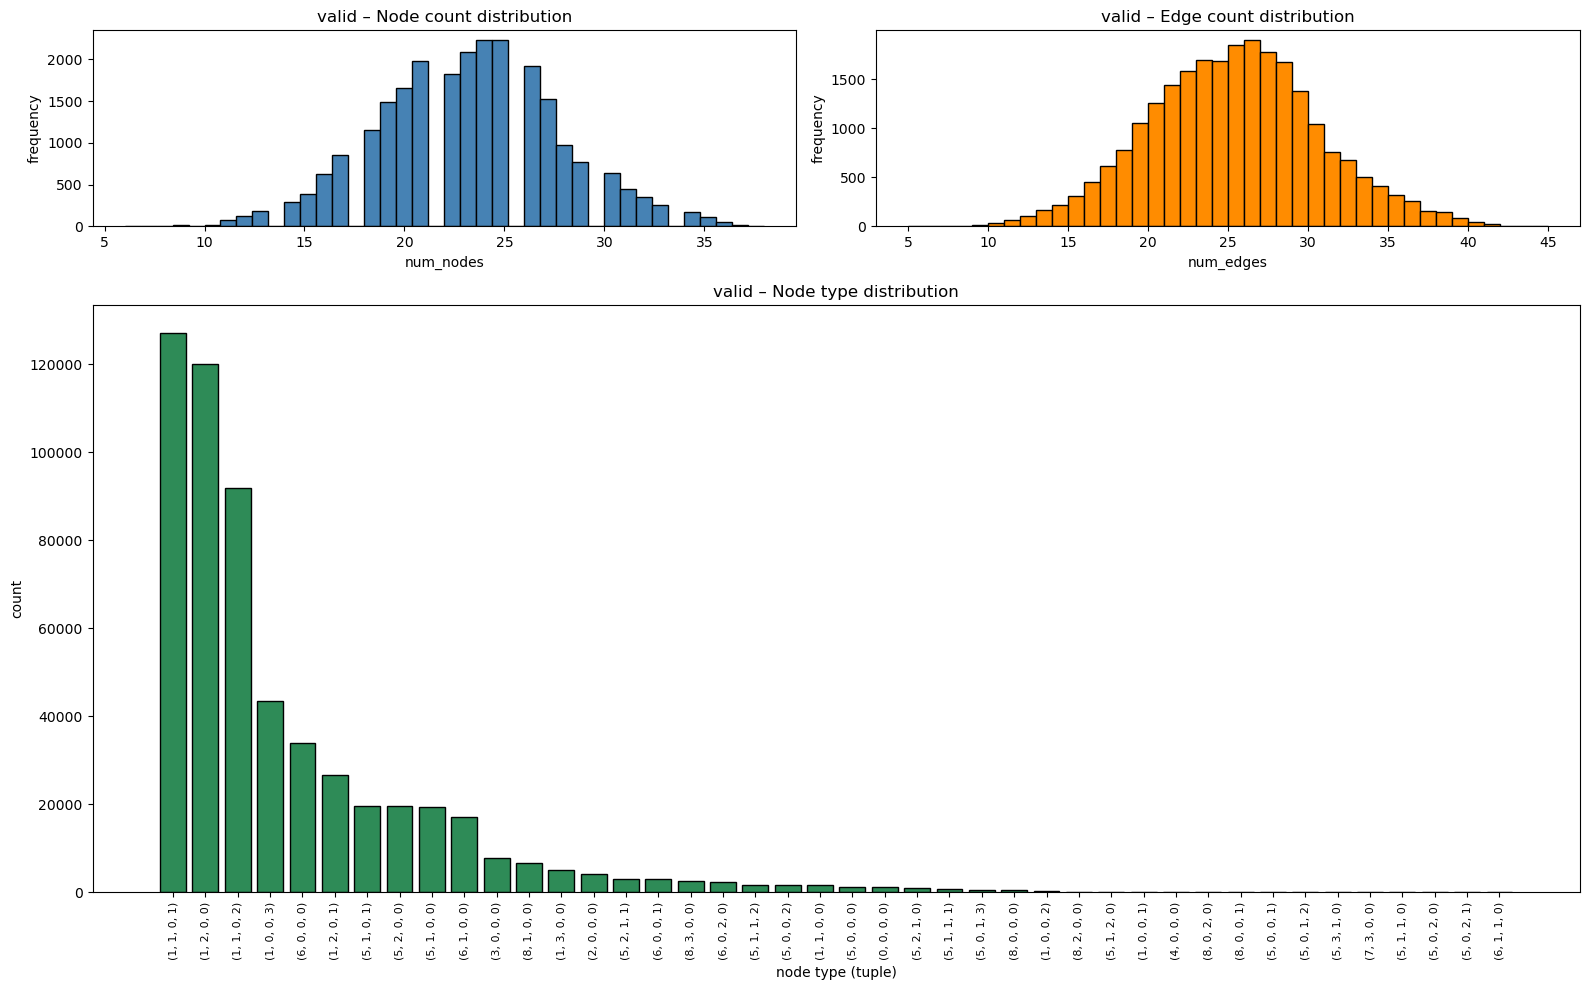

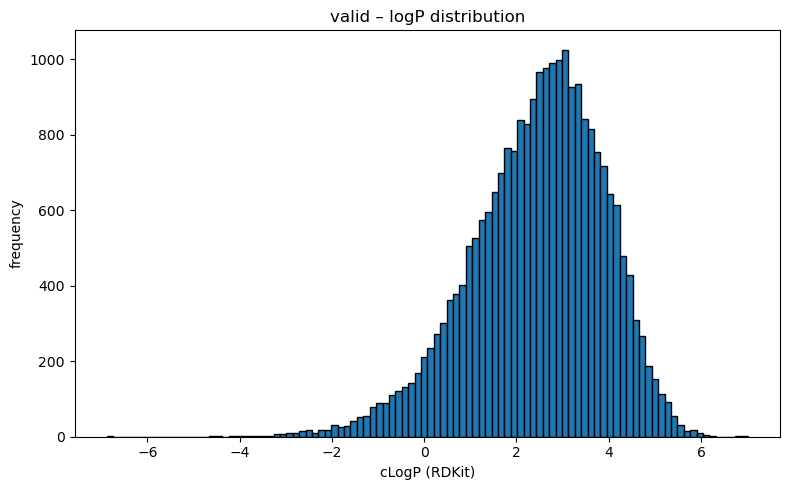

{'dataset': 'valid',
 'edges': {'max': 45,
           'mean': 24.87850276130088,
           'median': 25.0,
           'min': 5,
           'std': 5.315104283653143},
 'logp': {'max': 7,
          'mean': 2.4467468255596554,
          'median': 2.5975000858306885,
          'min': -6,
          'std': 1.439541991728351},
 'node_type_distribution': {(0, 0, 0, 0): 1235,
                            (1, 0, 0, 1): 138,
                            (1, 0, 0, 2): 301,
                            (1, 0, 0, 3): 43481,
                            (1, 1, 0, 0): 1603,
                            (1, 1, 0, 1): 127126,
                            (1, 1, 0, 2): 91928,
                            (1, 2, 0, 0): 120051,
                            (1, 2, 0, 1): 26614,
                            (1, 3, 0, 0): 5008,
                            (2, 0, 0, 0): 4145,
                            (3, 0, 0, 0): 7824,
                            (4, 0, 0, 0): 84,
                            (5, 0, 0, 0): 1344,
  

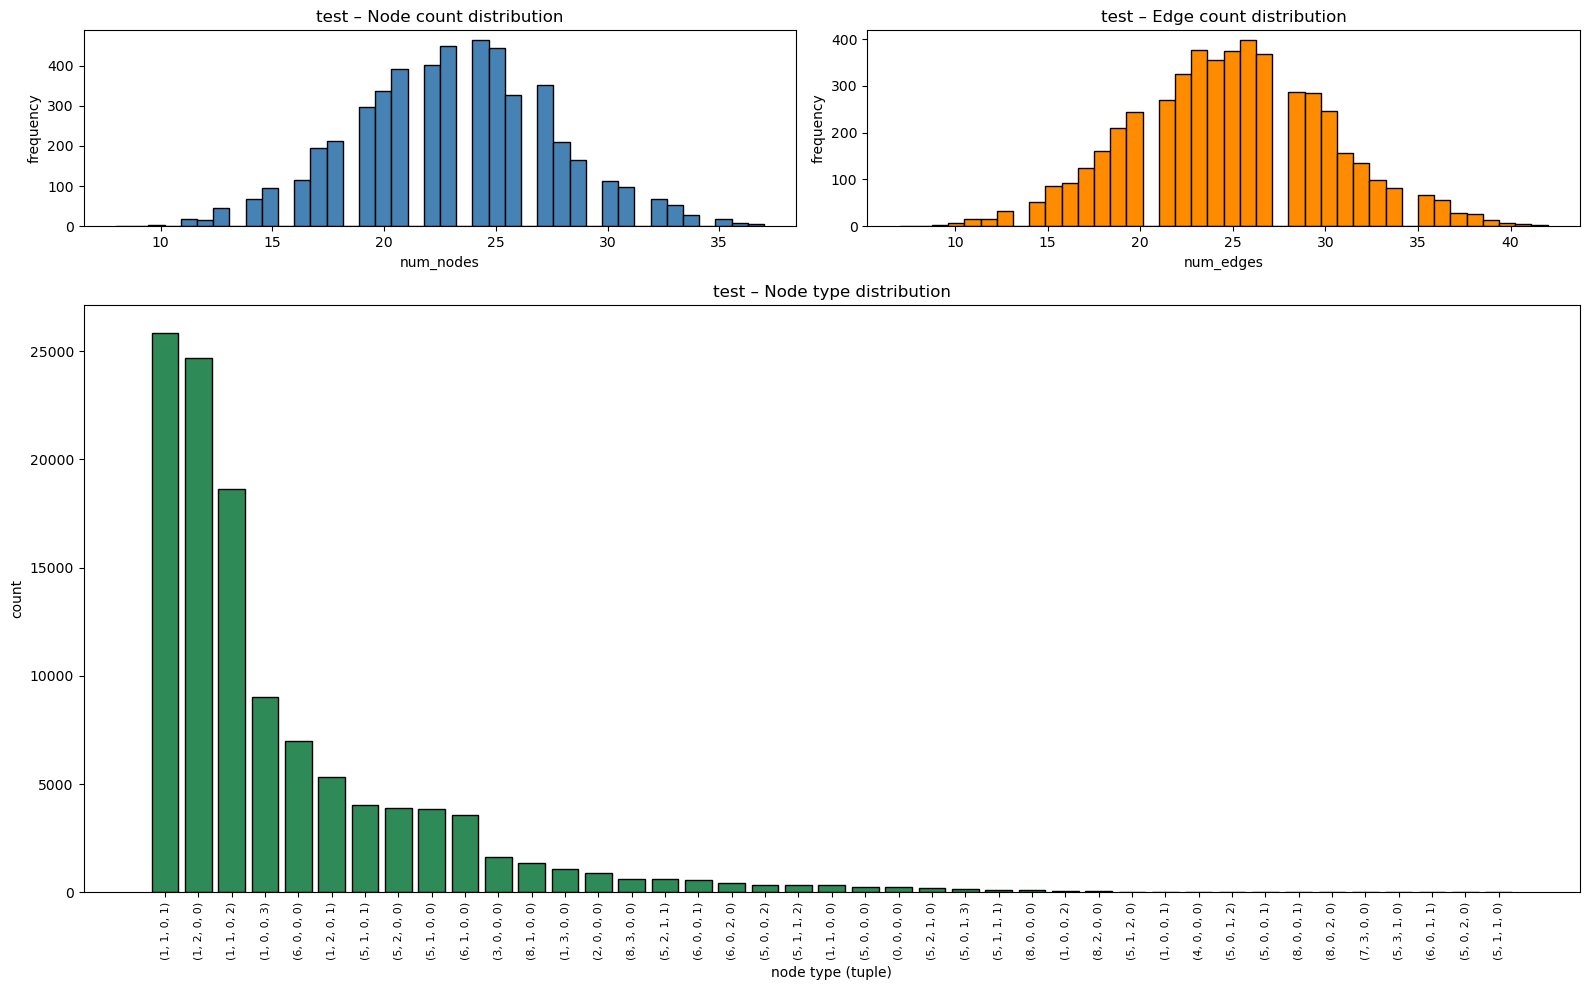

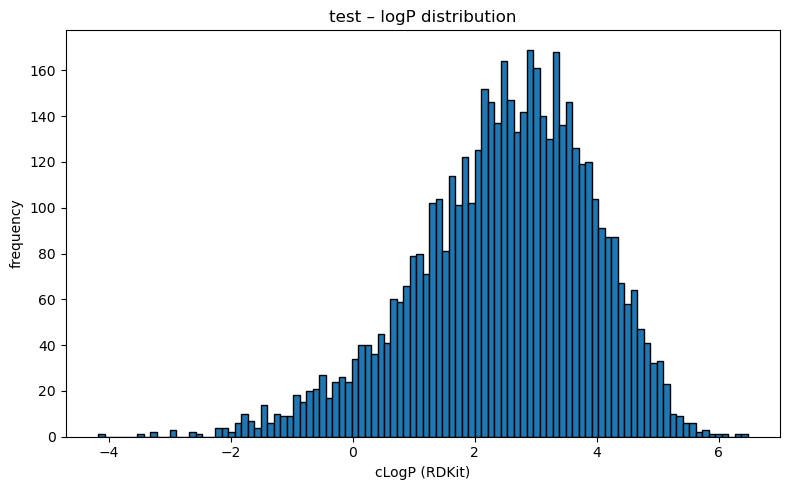

{'dataset': 'test',
 'edges': {'max': 42,
           'mean': 24.8302,
           'median': 25.0,
           'min': 7,
           'std': 5.31802822903837},
 'logp': {'max': 6,
          'mean': 2.4781004616978577,
          'median': 2.6153000593185425,
          'min': -4,
          'std': 1.4488123376691535},
 'node_type_distribution': {(0, 0, 0, 0): 246,
                            (1, 0, 0, 1): 31,
                            (1, 0, 0, 2): 67,
                            (1, 0, 0, 3): 9027,
                            (1, 1, 0, 0): 331,
                            (1, 1, 0, 1): 25842,
                            (1, 1, 0, 2): 18620,
                            (1, 2, 0, 0): 24673,
                            (1, 2, 0, 1): 5354,
                            (1, 3, 0, 0): 1071,
                            (2, 0, 0, 0): 899,
                            (3, 0, 0, 0): 1633,
                            (4, 0, 0, 0): 9,
                            (5, 0, 0, 0): 271,
                        

In [8]:
from pprint import pprint
from src.datasets.zinc_smiles_generation import ZincSmiles

for split in ["train", "valid", "test"]:
    ds = ZincSmiles(split=split)
    stats = analyze_dataset(ds, name=split)
    pprint(stats)

Creating new HyperNet instance.
Saved new HyperNet to /Users/akaveh/projects/kit/graph_hdc/_models/hypernet_ZincSmilesHRR7744F64_HRR_dim7744_s42_depth3_ecb0-f64.pt


/Users/akaveh/projects/kit/graph_hdc/.pixi/envs/default/lib/python3.13/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


torch.Size([1000, 7744])
Mean cosine similarity: 0.4122
Std  cosine similarity: 0.2303


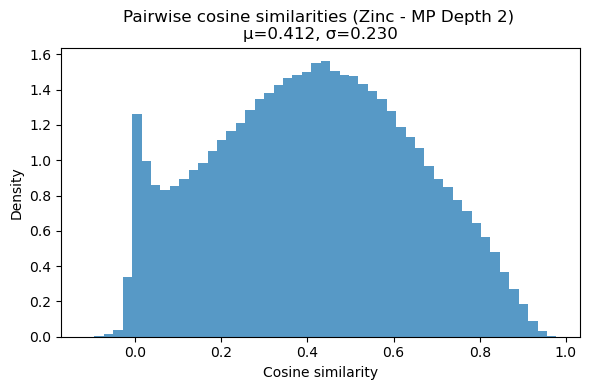

torch.Size([1000, 7744])
Mean cosine similarity: 0.2582
Std  cosine similarity: 0.2750


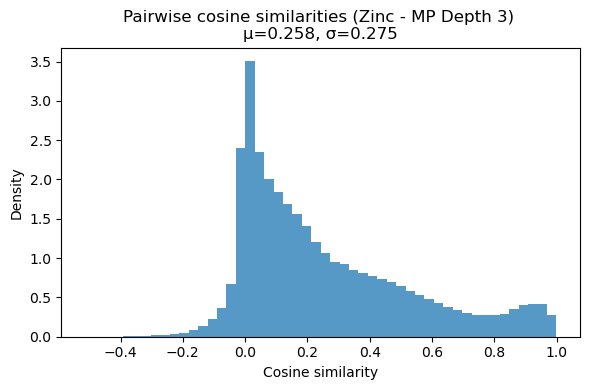

torch.Size([1000, 7744])
Mean cosine similarity: 0.1493
Std  cosine similarity: 0.3106


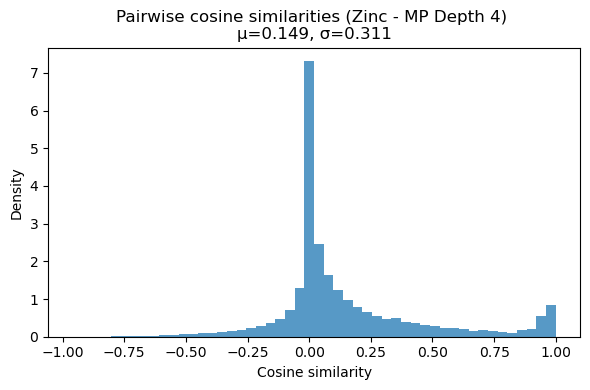

torch.Size([1000, 7744])
Mean cosine similarity: 0.0989
Std  cosine similarity: 0.3163


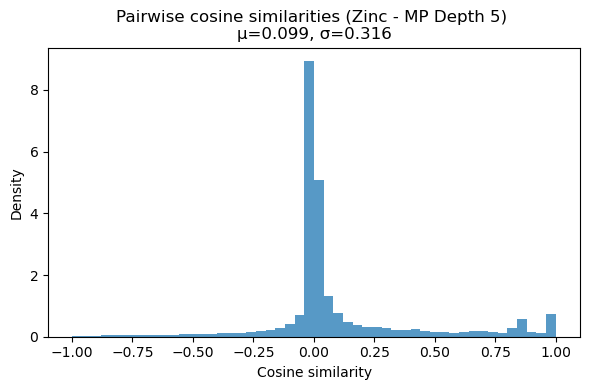

In [7]:
import torchhd
from src.datasets.zinc_smiles_generation import ZincSmiles
import torch
ds = ZincSmiles(split="train", enc_suffix="HRR7744")

# Number of samples
n_samples = 1000

# Ensure reproducibility
idxs = torch.randperm(len(ds))[:n_samples]
device = torch.device("cpu")
config = ZINC_SMILES_HRR_7744_CONFIG_F64
config.device = device
hypernet = load_or_create_hypernet(path=GLOBAL_MODEL_PATH, cfg=ZINC_SMILES_HRR_7744_CONFIG_F64).to(device)

for d in [2, 3, 4, 5]:
    hypernet.depth = d
    batch = next(iter(DataLoader(ds[idxs], batch_size=n_samples)))

    graph_terms = hypernet.forward(batch)["graph_embedding"]
    print(graph_terms.shape)

    # Pairwise cosine similarity matrix [1000, 1000]
    cos = torchhd.cos(graph_terms, graph_terms)

    # keep only unique, off-diagonal cosine similarities
    i, j = torch.triu_indices(cos.size(0), cos.size(1), offset=1)
    cs = cos[i, j]  # shape [N*(N-1)/2]

    # compute stats
    mean_cs = cs.mean().item()
    std_cs = cs.std(unbiased=True).item()

    print(f"Mean cosine similarity: {mean_cs:.4f}")
    print(f"Std  cosine similarity: {std_cs:.4f}")

    # plot
    plt.figure(figsize=(6, 4))
    plt.hist(cs.cpu().numpy(), bins=50, density=True, alpha=0.75)
    plt.xlabel("Cosine similarity")
    plt.ylabel("Density")
    plt.title(f"Pairwise cosine similarities (Zinc - MP Depth {d}) \nμ={mean_cs:.3f}, σ={std_cs:.3f}")
    plt.tight_layout()
    plt.show()